## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
#import file 
#congress_tweets = pd.read_csv("C://Users/mjkeh/CSS_Project5_Team3_Spring2022/data/116th Congressional Tweets and Demographics.csv")
# congress_tweets = pd.read_csv("/Users/neldeeb/Desktop/Spring 2022/Comp Social Sci - 273/Projects/Computational Social Science Project 5/data/116th Congressional Tweets and Demographics.csv")
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [4]:
#check the size of the dataset
print("Shape of current df:", congress_tweets.shape)

Shape of current df: (946791, 16)


In [5]:
#subset the data
## fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [6]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [7]:
#text data
congress_tweets['text'].head(30)

0     All of #OH14 salutes you, Patrolman St. Clair!...
1     In Case You Missed It: Bipartisanship works – ...
2     Wishing a happy #Passover to all those celebra...
3     RT @WhiteHouse President @realDonaldTrump just...
4     I just sent a letter demanding the Administrat...
5     The President’s attacks on Rep. @Ilhan are dis...
6     RT @HouseGOP It's time to get serious about ho...
7     RT @wdtnews With five confirmed COVID-19 cases...
8     RT @SVLeadershipGrp "We can only be game chang...
9     “This nation will remain the land of the free ...
10    This is true and we will address this soon.......
11    Preach. 🙏🏾 https://twitter.com/shondarhimes/st...
12    Among public institutions, @ASU is third in th...
13    There is no way Eric Swalwell should continue ...
14    NOW: on the air with @SethLeibsohn to talk abo...
15    Whistleblower reportedly worked with Joe Biden...
16    RT @MontclairNJGov Essex County Satellite Test...
17    I know there has been a lot of concern abo

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
#Remove emojis - FOUND ON GITHUB

def rem_emoji(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [9]:
#Remove line breaks 
#NE: added this to deal with issue later 
#EG: awesome, thanks!
def rem_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#Passing function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_lbreaks)

In [10]:
#Remove urls - FOUND ON STACK OVERFLOW
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [11]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") #NE: to get rid of retweets 
#     nlp.Defaults.stop_words.add("RT") #MJ: to get rid of rt in capital letters
    nlp.Defaults.stop_words.add("qt") #NE: to get rid of quote tweets 
#     nlp.Defaults.stop_words.add("QT") #MJ: to get rid of qt in capital letters
    nlp.Defaults.stop_words.add("amp") #NE: to get rid of accelerated mobile pages
#     nlp.Defaults.stop_words.add("AMP") #MJ: to get rid of accelerated mobile pages in capital letters
#     nlp.Defaults.stop_words.add("need") #NE: to get rid of the word "need" big on all wordclouds (thoughts?) 

    ##MJ : it may mean something, so I removed "need" from stop words
    #NE: I actually think we should remove the words that are big across all wordclouds because they have no meaning 
#     nlp.Defaults.stop_words.add("today") #NE: to get rid of the word "today" big on all wordclouds (thoughts?) 
    ##MJ : it may mean something, so I removed "today" from stop words    
    #NE: I actually think we should remove the words that are big across all wordclouds because they have no meaning 
    
    punc = set(punctuation)
    punc.add('–')
    punc.add('“')
    punc.add("‘")
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #NE: if we want to make the text all lower case 
    #EG: why not do this at the beginning so that we don't have to have take care of "rt" and "RT" individually?
    #NE: beginning where? do we need to do RT caps if this is all in the same function?
    #EG: sorry, I think I made this more confusing than it had to be. Ignore my comment above, I changed my mind. 

    
#     spacy_words = [word for word in spacy_words if not word.startswith('http')] 
    #MJ: this also removes some of the urls?
    #EG: is this necessary? I checked with this code and found no additional tweets that contained substring "http"
    # congress_tweets.loc[congress_tweets['text'].str.contains("http",case=False)]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [12]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
#EG: we had done this already. Is there a reason why we're repeating this step?
#NE: shouldn't we do it again after pre-processing?

In [13]:
#use the map() function to apply our rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
#NE: I AM NOT SURE IF WE NEED TO DO THIS FOR URLS AND EMOJI AS WELL OR IF IT PASSED ABOVE ##MJ- I removed these since they cause errors
#congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_urls(x))
#congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_emoji(x))
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head(30)

#EG: this puntuation did not delete "–". Do we care?
#NE: I don't know...
#EG: I added it above, just in case

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, , bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da..."
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ..."
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson..."
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp..."
9,1.222750e+18,RepValDemings,2020-01-29T23:59:40-05:00,“This nation will remain the land of the free ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[nation, remain, land, free, long, home, brave..."


In [14]:
#remove quotes
# congress_tweets['tokens']=congress_tweets['tokens'].replace(r"'","", regex=True)
#EG: quotes are already included in the puntuation list/set, so I don't think this is necessary.

In [15]:
#Remove blank spaces
def rem_spaces(text):
    text = [item.strip(' ') for item in text]  #removes white spaces in each item
    return [item for item in text if item]  #removes items that are empty strings

#Passing function to 'tokens'
congress_tweets['tokens'] = congress_tweets['tokens'].apply(rem_spaces)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [16]:
#Remove tweets with no words 
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9433, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [17]:
congress_tweets['tokens'][0] # text string -> tokens in list form

#EG: do we want to get rid of spaces?
#NE: YES! I couldn't figure out how!
#EG: added a function above. it looks like it worked.

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 'rooseveltlfox8']

In [18]:
#get rid of tokens that are brackets 
congress_tweets['length_tokens']=congress_tweets['tokens'].str.len()
congress_tweets=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])
print("Shape of current df:", congress_tweets.shape)
#EG: should we rename the new df congress_tweets to replace the original one? 
#NE: renamed it, so we don't need to use it moving forward, right?
#EG: yeah, that's right

Shape of current df: (9338, 18)


In [19]:
#Length of smallest tweet
congress_tweets['tokens'].str.len().min()

3

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

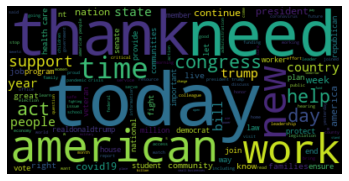

In [20]:
#WordCloud(ALL)

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [21]:
#political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
print("Shape of current df:", congress_tweets_R.shape)
congress_tweets_R.head()

Shape of current df: (3368, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",8


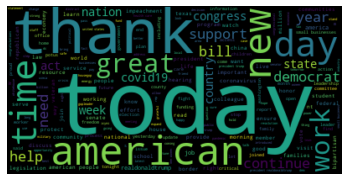

In [22]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [23]:
#political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
print("Shape of current df:", congress_tweets_D.shape)
congress_tweets_D.head()

Shape of current df: (5926, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


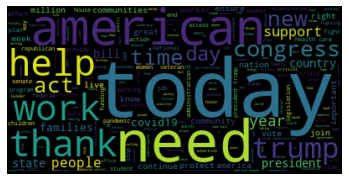

In [24]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [25]:
# EG: it looks like "today", "american", "need", "work", "day", "week", "year", "help", and "support" are (will be?) useless

In [26]:
#Legislator position- Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
print("Shape of current df:", congress_tweets_sen.shape)
congress_tweets_sen.head()

Shape of current df: (2228, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
12,1.105870e+18,SenatorSinema,2019-03-13T12:36:37-04:00,"Among public institutions, @ASU is third in th...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[public, institutions, asu, nation, student, f...",12
24,1.249040e+18,SenatorSinema,2020-04-11T14:19:58-04:00,"Arizonans: if you've lost your job, been furlo...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[arizonans, ve, lost, job, furloughed, hours, ...",20
28,1.105590e+18,MartinHeinrich,2019-03-12T18:15:17-04:00,Proud that my bipartisan bill with @SenAlexand...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788","[proud, bipartisan, bill, senalexander, signed...",23
34,1.105460e+18,PattyMurray,2019-03-12T09:12:00-04:00,ICYMI: The latest #TrumpBudget has massive tax...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[icymi, latest, trumpbudget, massive, tax, bre...",22
35,1.186770e+18,McConnellPress,2019-10-22T18:12:22-04:00,RT @ARCgov ARC Federal Co-Chairman Tim Thomas:...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[arcgov, arc, federal, cochairman, tim, thomas...",23


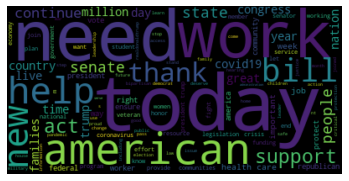

In [27]:
##WordCloud for Senators (NE ADDED)
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [28]:
#Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
print("Shape of current df:", congress_tweets_hrep.shape)
congress_tweets_hrep.head()

Shape of current df: (7110, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22


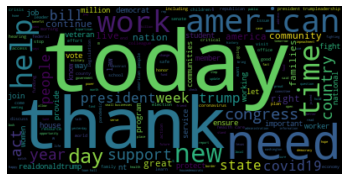

In [29]:
##WordCloud for House of Representatives (NE ADDED)
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [30]:
#EG: yes, definitely many of the most frequent words will be useless in predicting party and chamber.
# maybe we should just get rid of the top 10/20 words, like we discussed in lab?
#NE: I like the idea of getting rid of the top 10 words 

## Wordcloud shows that the most frequently used words do not vary a lot by party(e.g., today, thank, american). However, it shows that the republicans use "great" and "new" more frequently, while democrats use "healthcare" and "communities" more frequently- which is expected.

## Wordcloud also shows that both Senates and Representatives use "today" and "need" a lot. But Senates use "work" more often while Representatives use "thank" more often.

## EDA 2. Topic modeling 

In [31]:
# add column where tokens are concatenated into a single string
congress_tweets['tokens_str'] = congress_tweets['tokens'].str.join(" ")
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",31,greatest strength lies love repdebdingell john...
9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...
9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,Senate,Republican,"700,714","485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...
9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,5,Democrat,"673,215","897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard


In [32]:
#create tf-idf matrix
X = congress_tweets['tokens_str']
tf = TfidfVectorizer(tokenizer = rem_punc_stop) #creating an object : tf model

tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
dense_matrix = tfidf_matrix.todense() #remove all the columns where there are 0

In [33]:
tfidf_matrix

<9338x27798 sparse matrix of type '<class 'numpy.float64'>'
	with 178082 stored elements in Compressed Sparse Row format>

In [34]:
dense_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
#initialize model/ prespecify the parameter n => "5 topics"
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0) #random_state for reproducibility
lda = lda.fit(dense_matrix) # pass through our dense matrix

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [36]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [37]:
#prints out top words using different objects attached to our lda model
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
submit page ksleg nasa art easter ks02 competition congratulations covidreliefirs view english housescience phoenix strategic wind intelligence awesome won submissions

Topic #1:
newsletter getcovered legacy youth amy coney chemicals strongly world barrett paris netneutrality madam northern pfas jr saddened congratulations king lewis

Topic #2:
happy wishing daca birthday witnesses hands family day lgbtq tps today celebrating rsvp defendourdemocracy liberty innocent recipients legacy cdc world

Topic #3:
today people health trump act president need covid19 help house work congress american americans time new support bill thank care

Topic #4:
de la en el y para que del al los por su cohen las con internship un hispanic una o



/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
#get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.04302898, 0.04310323, 0.04307884, 0.8277562 , 0.04303274],
       [0.05124702, 0.05124587, 0.05202255, 0.58886844, 0.25661612],
       [0.32335179, 0.05931415, 0.49562214, 0.06255179, 0.05916013],
       ...,
       [0.02968447, 0.08982082, 0.03027549, 0.62818097, 0.22203825],
       [0.06277585, 0.0627744 , 0.06280303, 0.74887041, 0.06277631],
       [0.26686136, 0.04747762, 0.04766343, 0.59054045, 0.04745714]])

In [39]:
#merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics

,0,1,2,3,4,index,tweet_id,screen_name,datetime,text,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str
0,0.043029,0.043103,0.043079,0.827756,0.043033,0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",...,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...
1,0.051247,0.051246,0.052023,0.588868,0.256616,1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,...,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...
2,0.323352,0.059314,0.495622,0.062552,0.059160,2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,...,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight
3,0.046185,0.046186,0.046194,0.815217,0.046218,3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,...,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...
4,0.035854,0.035854,0.035904,0.856533,0.035855,4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,...,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9333,0.035601,0.035656,0.035642,0.857499,0.035602,9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,...,AR,2,Republican,"684,872","380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",31,greatest strength lies love repdebdingell john...
9334,0.036965,0.036979,0.036969,0.852094,0.036992,9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",...,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...
9335,0.029684,0.089821,0.030275,0.628181,0.222038,9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,...,MS,Senate,Republican,"700,714","485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...
9336,0.062776,0.062774,0.062803,0.748870,0.062776,9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,...,CT,5,Democrat,"673,215","897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard


In [40]:
#check the average weight of each topic across "party" using groupby
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican     0.078397
Democrat       0.069202
Independent    0.051220
Name: 0, dtype: float64
party
Republican     0.091419
Independent    0.082773
Democrat       0.080976
Name: 1, dtype: float64
party
Republican     0.092966
Democrat       0.090760
Independent    0.054192
Name: 2, dtype: float64
party
Independent    0.761638
Democrat       0.691824
Republican     0.668454
Name: 3, dtype: float64
party
Republican     0.068763
Democrat       0.067237
Independent    0.050177
Name: 4, dtype: float64


In [41]:
#check the average weight of each topic across "position" using groupby
grouped2 = df_w_topics.groupby('position')
for i in range(0, 5):
    print(grouped2[i].mean().sort_values(ascending=False))

position
Rep    0.072452
Sen    0.072376
Name: 0, dtype: float64
position
Sen    0.085477
Rep    0.084524
Name: 1, dtype: float64
position
Rep    0.093109
Sen    0.085877
Name: 2, dtype: float64
position
Sen    0.690817
Rep    0.681502
Name: 3, dtype: float64
position
Rep    0.068413
Sen    0.065453
Name: 4, dtype: float64


## NE: I added a grouped by party too

## MJK All 10 topics do not seem to have a lot of separation between senators and representatives, but we will visualize Topic 0 and Topic 9 that show little more difference.
 

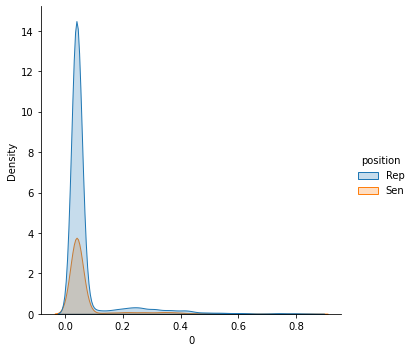

In [42]:
# Visualization- Topic 1 - for position
sns.displot(df_w_topics, x=df_w_topics[0], hue = "position", kind = 'kde', fill = 'true')
plt.show()

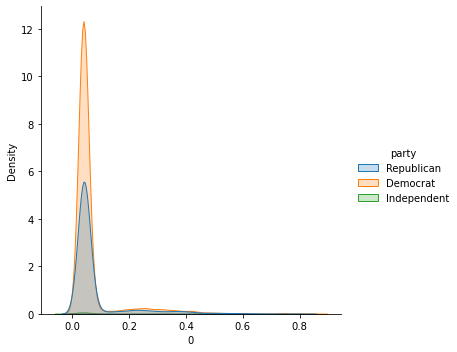

In [43]:
# Visualization- Topic 1 - for party 
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

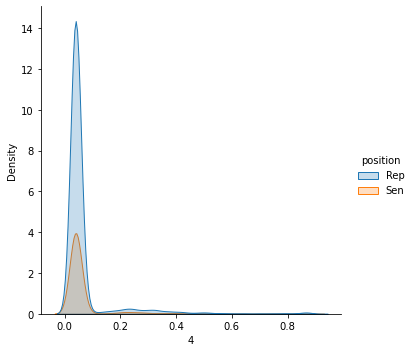

In [44]:
# Visualization- Topic 5 - for position
sns.displot(df_w_topics, x=df_w_topics[4], hue = "position", kind = 'kde', fill = 'true')
plt.show()

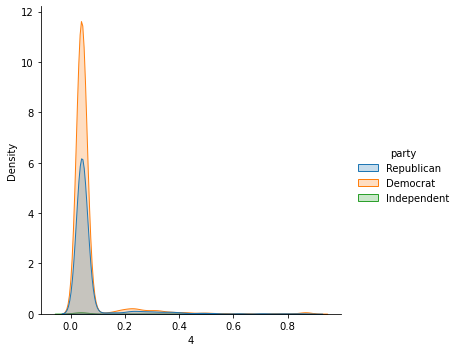

In [45]:
# Visualization- Topic 5 - for party 
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## NE: I added visualizations for party too 

## MJK: The visualizations show that the topics would NOT be good candidates to pass to a supervised learning algorithm if we were interested in predicting the position(senate/representative).

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

In [46]:
# congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
# congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
#EG: why are we doing this again? it just adds more processing work to the program
#NE: the code below doesn't run without this step
#EG: interesting... Oh, just checked. We just needed the second line, not the first one.

#congress_tweets['tokens'].head()

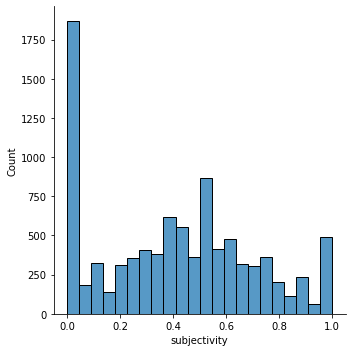

In [47]:
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

In [48]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,subjectivity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,0.0
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,0.0
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,1.0
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,0.0
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,1.0


##   Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Although the overall distribution is normal, more tweets were factual information(subjectivity ==0) compared to opinions(subjectivity ==1).

## 2) Choose two legislators, one liberal and one conservative

In [49]:
# Republican: David Joyce
congress_tweets_R.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",8


In [50]:
#congress_tweets_DavidJoyce = congress_tweets['text'][0]
#print(congress_tweets_DavidJoyce)

# EG: this only selects the very first tweet, which is Joyce's. Do we only want one tweet or all tweets by Joyce?
# if latter: congress_tweets[congress_tweets['name_wikipedia']=='David Joyce']
#NE: I agree it's meant to be per tweet not per word, moved your code below

In [51]:
congress_tweets_DavidJoyce = congress_tweets[congress_tweets["name_wikipedia"]=="David Joyce"].copy()

congress_tweets_DavidJoyce

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,subjectivity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,0.00000
2007,1.166760e+18,RepDaveJoyce,2019-08-28T13:29:18-04:00,"As the son of a wounded WWII vet, I applaud @P...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[son, wounded, wwii, vet, applaud, potus, deci...",22,son wounded wwii vet applaud potus decision ca...,0.15000
3106,1.161730e+18,RepDaveJoyce,2019-08-14T15:49:18-04:00,Always honored to speak at the annual 3chamber...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[honored, speak, annual, 3chamber, luncheon, s...",29,honored speak annual 3chamber luncheon spoke 1...,0.25000
3509,1.304440e+18,RepDaveJoyce,2020-09-11T11:06:06-04:00,Godspeed Detective QT @wkyc A sea of police o...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[godspeed, detective, wkyc, sea, police, offic...",14,godspeed detective wkyc sea police officers le...,0.00000
3929,1.268180e+18,RepDaveJoyce,2020-06-03T09:44:48-04:00,RT @AmChemMatters Ohio chemistry has stepped u...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[amchemmatters, ohio, chemistry, stepped, help...",27,amchemmatters ohio chemistry stepped help loca...,0.00000
4411,1.316030e+18,RepDaveJoyce,2020-10-13T11:10:07-04:00,Looking forward to visiting this local manufac...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[looking, forward, visiting, local, manufactur...",22,looking forward visiting local manufacturer to...,0.27500
4690,1.214590e+18,RepDaveJoyce,2020-01-07T11:56:51-05:00,"Good luck in your 2020 seasons, Cardinals! #c...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[good, luck, 2020, seasons, cardinals, cardsco...",23,good luck 2020 seasons cardinals cardscompete ...,0.60000
6494,1.189640e+18,RepDaveJoyce,2019-10-30T16:34:52-04:00,Always honored and humbled to join @the_USO in...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[honored, humbled, join, theuso, assembling, c...",18,honored humbled join theuso assembling care pa...,0.00000
6651,1.149330e+18,RepDaveJoyce,2019-07-11T10:58:15-04:00,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[energycommerce, hr, 728, title, viii, nursing...",19,energycommerce hr 728 title viii nursing workf...,0.00000
7462,1.288510e+18,RepDaveJoyce,2020-07-29T12:09:48-04:00,Great news for NEOH and the entire Buckeye Sta...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[great, news, neoh, entire, buckeye, state, us...",35,great news neoh entire buckeye state usdot fun...,0.58125


In [52]:
#sentiment analysis of one tweet 

# congress_tweets_DavidJoyce = "All of #OH14 salutes you, Patrolman St. Clair! 👮‍♂️ https://twitter.com/fox8news/status/1182779635840495622 QT @fox8news 5-year-old battling cancer becomes Bainbridge police officer for the day http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ via @RooseveltLFOX8"
# print("overall subjectivity score for David Joyce(Republican) is", TextBlob(congress_tweets_DavidJoyce).sentiment.subjectivity)
# for word in congress_tweets_DavidJoyce.split():
#     print(word, TextBlob(word).sentiment.subjectivity)

#EG: why not use "tokens" column rather than the original text? It's already cleaned up
#EG: also, do we want to get these values per word or per tweet?
#NE: I tried the code below but it didn't work 
#EG: there was a small typo in the code. I fixed it so now it works

In [53]:
# congress_tweets_DavidJoyce['subjectivity'] = congress_tweets_DavidJoyce['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
# EG: the code above was already done in the previous section
congress_tweets_DavidJoyce

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,subjectivity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,0.00000
2007,1.166760e+18,RepDaveJoyce,2019-08-28T13:29:18-04:00,"As the son of a wounded WWII vet, I applaud @P...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[son, wounded, wwii, vet, applaud, potus, deci...",22,son wounded wwii vet applaud potus decision ca...,0.15000
3106,1.161730e+18,RepDaveJoyce,2019-08-14T15:49:18-04:00,Always honored to speak at the annual 3chamber...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[honored, speak, annual, 3chamber, luncheon, s...",29,honored speak annual 3chamber luncheon spoke 1...,0.25000
3509,1.304440e+18,RepDaveJoyce,2020-09-11T11:06:06-04:00,Godspeed Detective QT @wkyc A sea of police o...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[godspeed, detective, wkyc, sea, police, offic...",14,godspeed detective wkyc sea police officers le...,0.00000
3929,1.268180e+18,RepDaveJoyce,2020-06-03T09:44:48-04:00,RT @AmChemMatters Ohio chemistry has stepped u...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[amchemmatters, ohio, chemistry, stepped, help...",27,amchemmatters ohio chemistry stepped help loca...,0.00000
4411,1.316030e+18,RepDaveJoyce,2020-10-13T11:10:07-04:00,Looking forward to visiting this local manufac...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[looking, forward, visiting, local, manufactur...",22,looking forward visiting local manufacturer to...,0.27500
4690,1.214590e+18,RepDaveJoyce,2020-01-07T11:56:51-05:00,"Good luck in your 2020 seasons, Cardinals! #c...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[good, luck, 2020, seasons, cardinals, cardsco...",23,good luck 2020 seasons cardinals cardscompete ...,0.60000
6494,1.189640e+18,RepDaveJoyce,2019-10-30T16:34:52-04:00,Always honored and humbled to join @the_USO in...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[honored, humbled, join, theuso, assembling, c...",18,honored humbled join theuso assembling care pa...,0.00000
6651,1.149330e+18,RepDaveJoyce,2019-07-11T10:58:15-04:00,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[energycommerce, hr, 728, title, viii, nursing...",19,energycommerce hr 728 title viii nursing workf...,0.00000
7462,1.288510e+18,RepDaveJoyce,2020-07-29T12:09:48-04:00,Great news for NEOH and the entire Buckeye Sta...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[great, news, neoh, entire, buckeye, state, us...",35,great news neoh entire buckeye state usdot fun...,0.58125


## The overall subjectivity score for David Joyce(Republican) is 0.0

In [54]:
# Democrat: Josh Harder
congress_tweets_D.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


In [55]:
congress_tweets_JoshHarder = congress_tweets[congress_tweets["name_wikipedia"]=="Josh Harder"].copy()
# congress_tweets_JoshHarder['subjectivity'] = congress_tweets_JoshHarder['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
congress_tweets_JoshHarder

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,subjectivity
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,0.000000
173,1.275220e+18,RepJoshHarder,2020-06-22T20:00:00-04:00,Big thanks to the @USChamber for giving me the...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[big, thanks, uschamber, giving, spirit, enter...",17,big thanks uschamber giving spirit enterprise ...,0.366667
856,1.333120e+18,RepJoshHarder,2020-11-29T14:00:01-05:00,Folks – tomorrow Congress is back in session –...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[folks, tomorrow, congress, session, blown, aw...",10,folks tomorrow congress session blown away sti...,0.000000
1042,1.117520e+18,RepJoshHarder,2019-04-14T16:00:00-04:00,Wishing our Sikh neighbors and friends a happy...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[wishing, sikh, neighbors, friends, happy, vai...",6,wishing sikh neighbors friends happy vaisakhi,1.000000
1637,1.328760e+18,RepJoshHarder,2020-11-17T13:00:00-05:00,"Folks – get a FREE Covid test today (Tuesday, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[folks, free, covid, test, today, tuesday, nov...",17,folks free covid test today tuesday nov 17 tur...,0.613333
1680,1.321630e+18,RepJoshHarder,2020-10-28T22:00:00-04:00,Farmworkers in the Valley literally feed the c...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[farmworkers, valley, literally, feed, country...",12,farmworkers valley literally feed country glad...,1.000000
1926,1.312560e+18,RepJoshHarder,2020-10-03T21:00:00-04:00,Human trafficking is disgusting and we have to...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[human, trafficking, disgusting, stamp, safety...",10,human trafficking disgusting stamp safety pled...,0.662963
2376,1.118270e+18,RepJoshHarder,2019-04-16T17:35:00-04:00,Every week I call people who write my office. ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[week, people, write, office, heard, week]",6,week people write office heard week,0.000000
3353,1.132750e+18,RepJoshHarder,2019-05-26T16:30:00-04:00,"We need the trade war to end, but until then, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[need, trade, war, end, need, support, farmers...",8,need trade war end need support farmers help,0.000000
3478,1.226980e+18,RepJoshHarder,2020-02-10T16:11:14-05:00,Thanks Darleen. Our veterans sacrificed life a...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[thanks, darleen, veterans, sacrificed, life, ...",8,thanks darleen veterans sacrificed life limb b...,0.200000


In [56]:
# congress_tweets_JoshHarder = "In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law! https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/"
# print("overall subjectivity score for Josh Harder(Democrat) is", TextBlob(congress_tweets_JoshHarder).sentiment.subjectivity)
# for word in congress_tweets_JoshHarder.split():
#     print(word, TextBlob(word).sentiment.subjectivity)

## The overall subjectivity score for Josh Harder(Democrat) is 0.85

## 3-1)  compare Democrats v. Republicans 

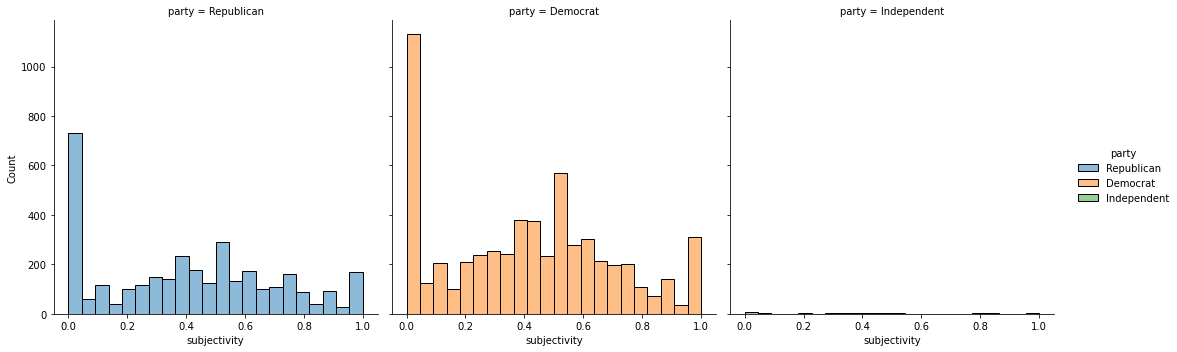

In [57]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

## Democrats tend to post more factual information(subjectivity ==0) than republicans

## 3-2) compare Senators v. Representatives 

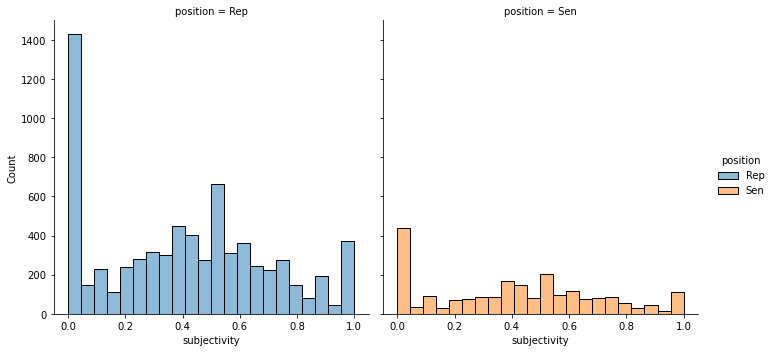

In [58]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

## Representatives tend to post more factual information(subjectivity ==0) than Senators

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [59]:
# congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text)) #made into string
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
# congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#EG: I removed the code above because tokens were already a string
#EG: we already have subjectivity

In [60]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length_tokens', 'tokens_str',
       'subjectivity', 'polarity'],
      dtype='object')

### Engineered Text Features

In [61]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

In [62]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,polarity,subjectivity
0,0.043029,0.043103,0.043079,0.827756,0.043033,0.000000,0.0
1,0.051247,0.051246,0.052023,0.588868,0.256616,0.000000,0.0
2,0.323352,0.059314,0.495622,0.062552,0.059160,0.800000,1.0
3,0.046185,0.046186,0.046194,0.815217,0.046218,0.000000,0.0
4,0.035854,0.035854,0.035904,0.856533,0.035855,-0.166667,1.0


### Bag-of-words or Tf-idf

In [63]:
# Frequency Based featurization
X = congress_tweets['tokens_str']
tf = TfidfVectorizer()

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [64]:
tfidf_df.head()

,03,08232020,082419,0amazon,0coors,0gm,0we,10,100,1000,...,zuckbuck,zuckerberg,zulfikar,zurfluh,ángeles,áreas,ōlelo,תודה,مبارک,نوروز
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#EG: I think we need to/want to get rid of all the "\n", which really just means linebreak in text.
# also, weren't emojis gone? Why are they back?
#NE: I got rid of line breaks in the pre-processing, I have no idea why the emojis are back. I even asked KQ about this and she didn't have an answer.
#EG: yeah, this is odd.

In [66]:
X.head(30)

#EG: there was a "praying-hands" emoji after Preach in 11. Now it's no longer there. I don't understand 
# where those damn emojis are coming from!!

0     oh14 salutes patrolman st clair fox8news 5year...
1     case missed bipartisanship works bill eradicat...
2      wishing happy passover celebrating seder tonight
3     whitehouse president realdonaldtrump signed bi...
4     sent letter demanding administration stop play...
5     president attacks rep ilhan dishonest dangerou...
6     housegop time holding china accountable china ...
7     wdtnews confirmed covid19 cases jefferson coun...
8     svleadershipgrp game changers accept responsib...
9     nation remain land free long home brave ” elme...
10    true address soon thehill charitable giving am...
11    preach shondarhimes homeschooling 6year old 8y...
12    public institutions asu nation student fulbrig...
13    way eric swalwell continue serve house intelli...
14    air sethleibsohn talk todays developments impe...
15    whistleblower reportedly worked joe biden ukra...
16    montclairnjgov essex county satellite testing ...
17    know lot concern food supply chain bay are

In [67]:
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,0.000000,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,0.000000,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,1.000000,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,0.000000,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,1.000000,-0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,...,Republican,"684,872","380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",31,greatest strength lies love repdebdingell john...,0.598609,0.431725
9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...,0.650000,-0.550000
9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,...,Republican,"700,714","485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...,0.678571,-0.271429
9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,...,Democrat,"673,215","897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard,0.888889,0.500000


### Word Embedding - N STOPPED HERE 

In [68]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [69]:
#Using the function to re-tokenize
# congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [70]:
# Drop the tokens that aren't words in the model
model_words = []
i=0
for tweet in congress_tweets['tokens']:
    doc = [word for word in tweet if word in model.wv.index_to_key]
    if len(doc) < 1:
        model_words.append(i)
    i =i+1

print(model_words)

#Shape of congress_tweets_notempty
congress_tweets.shape


#Drop if the index is the same
congress_tweets_clean=congress_tweets.drop(congress_tweets.index[[model_words]])

congress_tweets_clean.shape

#NE: tried to get rid of the mising words but I get this error below

[1155, 1186, 4627, 5260, 7205, 7422]


/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


(9332, 21)

In [71]:
congress_tweets_clean.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,1.0,-0.166667


In [72]:
len(congress_tweets_clean['tokens'][0])

14

In [73]:
doc = [word for word in congress_tweets_clean['tokens'][0] if word in model.wv.index_to_key]
len(doc)

6

In [74]:
doc [0:5]
#NE: not sure why I am still getting an empty word 

['st', 'battling', 'cancer', 'police', 'officer']

In [75]:
#Now let's grab the first vector each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

-0.19128712

In [76]:
#create this for every word - get all the means (FROM LAB)
#Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#get an average embedding for each doument 
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [77]:
# EG: For some reason, these 6 tweets give us problems to the point that they break the program.
# Until we figure out why they're giving us problems, I thought that it's better to remove them
# from the data. Everything else works just fine now.
print(len(congress_tweets))
congress_tweets.drop(index=[1167,1199,4672,5311,7280,7498],inplace=True)
print(len(congress_tweets))

9338
9332


In [78]:
# Initialize an array for the size of the corpus
#each word is represented by 100 element list, so then it averages the first element for each word across all the words
empty_list_embeddings_means = []
for doc in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

##NE: I keep getting an error that says "NEED AT LEAST ONE ARRAY TO CONCATENATE" even though I got rid of missing words
# EG: if you type print(doc), you'll see that we're getting emojis. I'm assuming it has something to do with that.

In [79]:
doc_average_embeddings

array([[-0.19128712,  0.28499696,  0.17923655, ..., -0.2958682 ,
         0.07686913,  0.09502434],
       [-0.16396448,  0.23066705,  0.13671291, ..., -0.27295858,
         0.0724647 ,  0.0582363 ],
       [-0.18447132,  0.27710718,  0.17144616, ..., -0.2947057 ,
         0.0843384 ,  0.09437148],
       ...,
       [-0.17372255,  0.2381867 ,  0.14789844, ..., -0.25714228,
         0.07314839,  0.0728398 ],
       [-0.2630883 ,  0.36969075,  0.22667445, ..., -0.4020482 ,
         0.12130202,  0.1085855 ],
       [-0.23939466,  0.3416203 ,  0.22623472, ..., -0.38005745,
         0.10675403,  0.11896977]], dtype=float32)

In [80]:
#AVE EMBEDDINGS FOR EACH DOC 
doc_average_embeddings.shape

(9332, 100)

In [81]:
#create dataframe
word2vec_features_df = pd.DataFrame(doc_average_embeddings) 
word2vec_features_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.191287,0.284997,0.179237,-0.001824,0.064374,-0.446322,0.101569,0.648424,-0.245182,-0.164722,...,0.246324,0.087329,0.042283,0.118742,0.493705,0.247427,0.128755,-0.295868,0.076869,0.095024
1,-0.163964,0.230667,0.136713,0.001498,0.068240,-0.387339,0.116426,0.552471,-0.210267,-0.160567,...,0.202896,0.074231,0.026993,0.110792,0.424461,0.202050,0.102412,-0.272959,0.072465,0.058236
2,-0.184471,0.277107,0.171446,-0.002515,0.069771,-0.429752,0.105643,0.641358,-0.252011,-0.158015,...,0.232414,0.098394,0.036585,0.119936,0.479536,0.238048,0.120576,-0.294706,0.084338,0.094371
3,-0.281962,0.379184,0.201304,0.014639,0.126739,-0.587831,0.168941,0.873109,-0.333903,-0.229852,...,0.321048,0.103242,0.052037,0.156840,0.670986,0.327984,0.176337,-0.409155,0.102508,0.108522
4,-0.212286,0.296868,0.174382,-0.007342,0.063452,-0.453355,0.117658,0.647885,-0.260192,-0.180341,...,0.266835,0.089178,0.028808,0.108555,0.503636,0.257006,0.162948,-0.306134,0.089550,0.084361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9327,-0.231417,0.333248,0.201184,-0.004679,0.075759,-0.519796,0.131838,0.744408,-0.291833,-0.195959,...,0.289043,0.104879,0.037834,0.128244,0.579682,0.287694,0.159904,-0.360724,0.096896,0.102944
9328,-0.232635,0.332571,0.193413,-0.014560,0.061097,-0.512425,0.124941,0.714520,-0.289843,-0.205851,...,0.309169,0.095324,0.021421,0.108320,0.561031,0.293280,0.208129,-0.344628,0.110944,0.086249
9329,-0.173723,0.238187,0.147898,0.001390,0.050750,-0.367324,0.098002,0.530094,-0.211015,-0.142835,...,0.209348,0.071595,0.024106,0.097484,0.417389,0.211818,0.112506,-0.257142,0.073148,0.072840
9330,-0.263088,0.369691,0.226674,-0.012120,0.075085,-0.582201,0.143804,0.826987,-0.326754,-0.229992,...,0.321369,0.112404,0.034414,0.140953,0.642728,0.321104,0.196443,-0.402048,0.121302,0.108585


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**